<a href="https://colab.research.google.com/github/mnkajan/astro/blob/main/final/exoplanets_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exoplanets final

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 45 kB 2.6 MB/s 


## Question 1:

We'll combine a table from Fischer & Valenti (2005) on planet detections and another from Valenti & Fischer (2005) about stellar properties to construct a histogram of stellar populations with and without planets as a function of metallicity:

In [54]:
# 'stars with uniform planet detectability' table from Fischer & Valenti (2005)
!wget -nv https://raw.githubusercontent.com/mnkajan/astro/main/exoplanets/final/table3_fv05.txt
table3_labels = ['ID', 'f_ID']
table3 = pd.read_csv('table3_fv05.txt', delimiter=r'\s+', names=table3_labels, skiprows=15, header=None)

# 'spectroscopically determined stellar properties' table from Valenti & Fischer (2005)
!wget -nv https://raw.githubusercontent.com/mnkajan/astro/main/exoplanets/final/table8_vf05.txt
table8_labels = ['ID', 'Name', 'Teff', 'log(g)', 'M/H', 'Na/H', 'Si/H', 'Ti/H', 'Fe/H', 'Ni/H', 'vsini', 'VRad', 'C-RMS', 'L-RMS', 'K', 'A', 'L']
table8 = pd.read_csv('table8_vf05.txt', delimiter=r'\s+', names=table8_labels, skiprows=35, header=None)

# combine planet detection data from table3 with stellar properties from table8
table = pd.merge(table3, table8, how='inner', left_on='ID', right_on='Name')

2021-12-19 05:54:34 URL:https://raw.githubusercontent.com/mnkajan/astro/main/exoplanets/final/table3_fv05.txt [11841/11841] -> "table3_fv05.txt.1" [1]
2021-12-19 05:54:35 URL:https://raw.githubusercontent.com/mnkajan/astro/main/exoplanets/final/table8_vf05.txt [99015/99015] -> "table8_vf05.txt.1" [1]


In [195]:
# make sure merged table looks fine
table

,ID_x,f_ID,ID_y,Name,Teff,log(g),M/H,Na/H,Si/H,Ti/H,Fe/H,Ni/H,vsini,VRad,C-RMS,L-RMS,K,A,L
0,HD142,P,3,HD142,6249,4.19,0.08,0.07,0.10,0.07,0.10,0.04,10.4,6.0,0.53,0.99,0.0,6,0
1,HD2039,P,17,HD2039,5941,4.38,0.30,0.41,0.33,0.25,0.32,0.34,3.2,8.3,1.99,2.17,0.0,4,0
2,HD4203,P,36,HD4203,5702,4.36,0.33,0.50,0.40,0.40,0.45,0.47,1.2,-14.7,1.54,1.69,1.0,0,0
3,HD8574,P,71,HD8574,6050,4.20,-0.01,-0.03,-0.00,0.04,-0.01,-0.03,4.5,19.4,0.78,0.99,1.0,0,0
4,HD10697,P,97,HD10697,5680,4.12,0.10,0.17,0.13,0.15,0.19,0.17,2.5,-45.4,0.99,1.13,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,HD223315,S,1035,HD223315,5606,4.34,0.28,0.29,0.28,0.25,0.30,0.31,2.2,-2.5,0.66,1.50,1.0,0,0
838,HD223498,S,1036,HD223498,5628,4.58,0.14,0.17,0.18,0.17,0.23,0.18,0.0,-23.7,1.14,1.21,1.0,0,0
839,HD223691,S,1037,HD223691,5506,4.08,-0.20,-0.22,-0.16,-0.08,-0.17,-0.19,2.1,2.2,0.59,0.99,1.0,0,0
840,HD224156,S,1038,HD224156,5496,4.58,0.03,-0.05,0.02,0.04,-0.03,-0.06,1.7,15.3,0.95,1.42,1.0,0,0


In [55]:
# pulling out stars with (P) and without (NP) planets
star_P = table.loc[table.f_ID == 'P']
star_NP = table.loc[table.f_ID == 'S']
print(len(star_P), len(star_NP))

47 795


In [5]:
# check range of metallicity
print(np.min(table['Fe/H']), np.max(table['Fe/H']))
print(np.min(table['M/H']), np.max(table['M/H']))

-1.95 0.56
-1.92 0.46


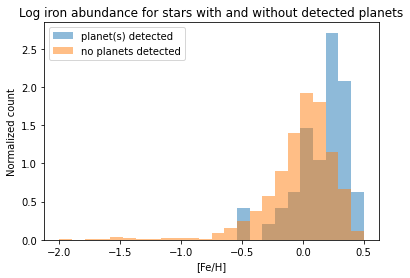

In [6]:
# plotting log iron abundance for stellar populations P and NP
bins = np.linspace(-2, 0.5, 25)
plt.hist(star_P['Fe/H'], density='True', bins=bins, label='planet(s) detected', alpha=0.5)
plt.hist(star_NP['Fe/H'], density='True', bins=bins, label='no planets detected', alpha=0.5)
plt.title('Log iron abundance for stars with and without detected planets')
plt.ylabel('Normalized count')
plt.xlabel('[Fe/H]')
plt.legend()
plt.show()

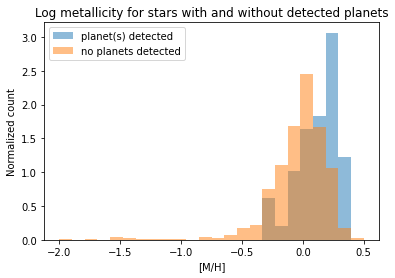

In [7]:
# looking at the more general log metallicity, out of interest
bins = np.linspace(-2, 0.5, 25)
plt.hist(star_P['M/H'], density='True', bins=bins, label='planet(s) detected', alpha=0.5)
plt.hist(star_NP['M/H'], density='True', bins=bins, label='no planets detected', alpha=0.5)
plt.title('Log metallicity for stars with and without detected planets')
plt.ylabel('Normalized count')
plt.xlabel('[M/H]')
plt.legend()
plt.show()

By eye, the population of stars with known planets appears to be shifted towards a higher metallicity than the population of stars where no planets have been detected.

## Question 2:

We'll begin with the table from homework \#2, with two more columns: metallicity $\mathrm{[Fe/H]}$, and prior probability $p(f)$.

This time we describe the fraction of stars with planets as a function of metallicity, i.e. $f = f(\mathrm{[Fe/He]}_i)$.

~~The simplest prior we can assume about planet occurrence is a flat distribution, say p = 0.5 (or "50% of stars have planets," for another callback to homework \#2). I wonder whether we could also assume from question 1 that planet occurrence increases with stellar metallicity, but will leave it as a flat prior for simplicity.~~ Never mind, turns out the simplest prior is that $f$ must be between 0 and 1. Each star represents a Bernoulli trial where the probability of detecting at least one planet is given by the binomial distribution.

I will also assume that, as before, planets 1 and 2 have detected planets while 3 and 4 do not.

| star | detection | metallicity | $p(f)$ | $p(D_i|f)$ |
| --- | --- | --- | --- | --- |
| 1 | 1 | $\mathrm{[Fe/H]}_1$ | $0 \le f \le 1$ | $f(\mathrm{[Fe/He]}_1)$ |
| 2 | 1 | $\mathrm{[Fe/H]}_2$ | $0 \le f \le 1$ | $f(\mathrm{[Fe/He]}_2)$ |
| 3 | 0 | $\mathrm{[Fe/H]}_3$ | $0 \le f \le 1$ | $1 - f(\mathrm{[Fe/He]}_3)$ |
| 4 | 0 | $\mathrm{[Fe/H]}_4$ | $0 \le f \le 1$ | $1 - f(\mathrm{[Fe/He]}_4)$ |

The probability of planet detection for these four stars would now be:

$p(\{D\}|f) = f(\mathrm{[Fe/He]}_1) \cdot f(\mathrm{[Fe/He]}_2) \cdot (1 - f(\mathrm{[Fe/He]}_3) \cdot (1 - f(\mathrm{[Fe/He]}_4)$

## Question 3:

Now we will assume, per Fischer & Valenti (2005), that $f$ follows a power law:

$f(\mathrm{[Fe/H]}) = \alpha \cdot 10^{\beta \mathrm{[Fe/H]}}$,

which gives us a probability of detection:

$p(\{D\}|f) = (\alpha \cdot 10^{\beta \mathrm{[Fe/H]}_1}) \cdot (\alpha \cdot 10^{\beta \mathrm{[Fe/H]}_2}) \cdot (1 - \alpha \cdot 10^{\beta \mathrm{[Fe/H]}_3}) \cdot (1 - \alpha \cdot 10^{\beta \mathrm{[Fe/H]}_4})$

We can generalize this for $x$ stars with planets and $n$ total stars as something like:

$p(\{D\}|f) = \prod_{i=1}^{x} \alpha \cdot 10^{\beta \mathrm{[Fe/H]}_i} \cdot \prod_{j=1}^{n-x} (1 - \alpha \cdot 10^{\beta \mathrm{[Fe/H]}_j})$

## Question 4:

We'll calculate the probability of detection with the prior that $f = [0,1]$ because it's a probability distribution.

##### Garbage attempts

In [8]:
# calculate f = alpha * 10^(beta * [Fe/H])
def fraction(alpha, beta, FeH):
  return alpha * 10**(beta * FeH)

# calculate likelihood p(D|f) from product of p(D_i|f) values
def log_likelihood(detection, alpha, beta, metallicity):
  likelihood = np.zeros(len(detection))
  for i, FeH in enumerate(metallicity):
    if detection[i]=='P':
      likelihood[i] = fraction(alpha, beta, FeH)
    elif detection[i]=='S':
      likelihood[i] = 1 - fraction(alpha, beta, FeH)
  if np.prod(likelihood) <= 0 or np.prod(likelihood) > 1:
    return -np.inf
  else:
    return np.log(np.prod(likelihood))

# The ln-probability function is just proportional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

def log_probability(alpha, beta, planets, noplanets):
    lp = log_prior(alpha, beta,)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, planets, noplanets)

# test where this should be zero and non-zero
print(log_likelihood(table['f_ID'], 0., 0., table['Fe/H']))
print(log_likelihood(table['f_ID'], 0.04, 2.3, table['Fe/H']))

-inf
-172.61981115801004


In [ ]:
import emcee
pos = [0.03, 2.0] + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(table['Fe/H']))

ndim, nwalkers = 5, 100
ivar = 1. / np.random.rand(ndim)
p0 = np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[ivar])
sampler.run_mcmc(p0, 10000)

# burn in
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()

# production
pos, _, _ = sampler.run_mcmc(pos, 4000)

# triangle plot of PDFs using DFMs corner package
corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);

impor

In [ ]:
import emcee
import corner

# calculate likelihood p(D|f) from product of p(D_i|f) values
def lnlike(theta, detection, metallicity):
  alpha, beta = theta
  likelihood = np.zeros(len(detection))
  for i, FeH in enumerate(metallicity):
    if detection[i]=='P':
      likelihood[i] = fraction(alpha, beta, FeH)
    elif detection[i]=='S':
      likelihood[i] = 1 - fraction(alpha, beta, FeH)
  if np.prod(likelihood) <= 0 or np.prod(likelihood) > 1:
    return -np.inf
  else:
    return np.log(np.prod(likelihood))

def lnprior(theta):
  alpha, beta = theta
  if 0. < alpha < 0.1 and 0. < beta < 3.:
    return 0.0
  else:
    return -np.inf

def lnprob(theta, detection, metallicity):
  lp = lnprior(theta)
  if np.isfinite(lp):
    return lp + lnlike(theta, detection, metallicity)
  else:
    return -np.inf

pos = [0.03, 2.0] + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(table['f_ID'], table['Fe/H']))
sampler.run_mcmc(pos, 5000, progress=True)

In [ ]:
# calculate likelihood p(D|f) from product of p(D_i|f) values
def lnlike(theta, detection, metallicity):
  alpha, beta = theta
  likelihood = np.zeros(len(detection))
  for i, FeH in enumerate(metallicity):
    if detection[i]=='P':
      likelihood[i] = fraction(alpha, beta, FeH)
    elif detection[i]=='S':
      likelihood[i] = 1 - fraction(alpha, beta, FeH)
  if np.prod(likelihood) <= 0 or np.prod(likelihood) > 1:
    return -np.inf
  else:
    return np.log(np.prod(likelihood))

def lnprior(theta):
  alpha, beta = theta
  if 0. < alpha < 0.1 and 0. < beta < 3.:
    return 0.0
  else:
    return -np.inf

def lnprob(theta, detection, metallicity):
  lp = lnprior(theta)
  if np.isfinite(lp):
    return lp + lnlike(theta, detection, metallicity)
  else:
    return -np.inf

pos = [0.03, 2.0] + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(table['f_ID'], table['Fe/H']))
sampler.run_mcmc(pos, 5000, progress=True)

##### Less garbage attempt

In [8]:
# for loops are a crime against humanity so let's speed things up

def fraction(alpha, beta, FeH):
  return alpha * 10**(beta * FeH)

def lnlike(theta, P_met, NP_met):
  alpha, beta = theta
  like = np.prod(fraction(alpha, beta, P_met)) * np.prod(1 - fraction(alpha, beta, NP_met))
  if like <= 0 or like > 1:  # prior: f must be between 0 and 1, so likelihood must be as well
    return -np.inf
  else:
    return np.log(like)

def lnprior(theta):
  alpha, beta = theta
  # set some constraints on outliers
  if 0. < alpha < 0.1 and 0. < beta < 3.:
    return 0.0
  else:
    return -np.inf

def lnprob(theta, P_met, NP_met):
  ll = lnlike(theta, P_met, NP_met)
  lp = lnprior(theta)
  if np.isfinite(lp) and np.isfinite(ll):
    return lp + ll
  else:
    return -np.inf

In [111]:
# test where this should be zero and non-zero
print(lnlike([0., 0.], star_P['Fe/H'], star_NP['Fe/H']))
print(lnlike([0.04, 2.3], star_P['Fe/H'], star_NP['Fe/H']))

-inf
-172.61981115801004


In [9]:
# mcmc search for alpha and beta
import emcee

# initialize with a first guess from F&V plus some noise
init = np.hstack([0.03, 2.])
ndim, nwalkers = 2, 50
pos = [init + init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(star_P['Fe/H'], star_NP['Fe/H']))
#sampler.run_mcmc(pos, 1000, progress=True);

# speed up a bit with multiprocessing
from multiprocessing import Pool
with Pool() as pool:
  sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(star_P['Fe/H'], star_NP['Fe/H']), pool=pool)
  sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████| 1000/1000 [01:17<00:00, 12.86it/s]


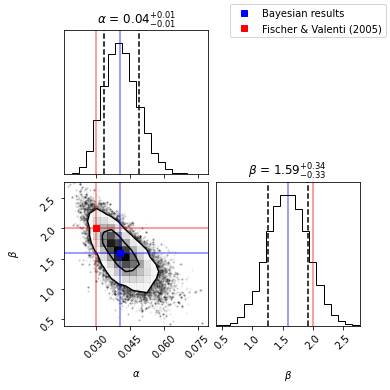

In [11]:
import corner

# remove initial iterations
burnout = 100
samples = sampler.chain[:,burnout:,:].reshape((-1,ndim))

# corner plot time
figure = corner.corner(samples, labels=[r'$\alpha $', r'$\beta $'], show_titles=True, quantiles=[.16,.84], levels=(1-np.exp(-0.5), 1-np.exp(-2)))
best = np.hstack([corner.quantile(samples[:,0], [0.5]), corner.quantile(samples[:,1], [0.5])])
corner.overplot_lines(figure, best, color='blue', alpha=0.5)
corner.overplot_points(figure, best[None], color='blue', marker="s", label='Bayesian results')
corner.overplot_lines(figure, init, color='red', alpha=0.5)
corner.overplot_points(figure, init[None], color='red', marker="s", label='Fischer & Valenti (2005)')
figure.legend()
figure.show()

Bayesian analysis gives us $\alpha = 0.04$ and $\beta = 1.59$; both FV05 values lie just outside the $1 \sigma$ confidence intervals but are within the $2 \sigma$ contour.

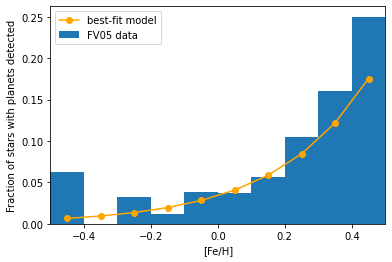

In [564]:
# now histogram
#pd.options.mode.chained_assignment = None  # default='warn'
bins = np.linspace(-0.5,0.5,11)
table['binning'] = pd.cut(table['Fe/H'], bins=bins, include_lowest=True)
star_P['binning'] = pd.cut(star_P['Fe/H'], bins=bins, include_lowest=True)

numer = star_P.groupby('binning').count().reset_index().Name # stars with planets detected per bin
denom = table.groupby('binning').count().reset_index().Name  # total stars per bin
frac = np.array(numer/denom)  # fraction of stars with planets per bin

# we have to plot bins[:-1] because pd.cut gives bins as intervals (n=10)
# rather than the edges that we defined with linspace (n=11)
plt.bar(bins[:-1], frac, width=0.1, align='edge', label='FV05 data')
plt.plot(bins[:-1]+0.05, fraction(best[0], best[1], bins[:-1]), color='orange', marker='o', label='best-fit model')  # +0.05 is to push over a half-width so the points align with the bin centers
plt.xlim(-0.5, 0.5)
plt.xlabel('[Fe/H]')
plt.ylabel('Fraction of stars with planets detected')
plt.legend()
plt.show()

# Question 5:

Plotting the discrepancy per bin between $f_0$ measured from the data and $f_p$ predicted by our best-fit model, we have:

Text(0.5, 1.0, 'Difference between model and data')

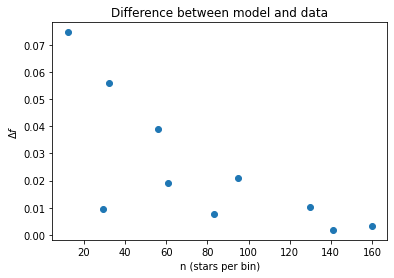

In [562]:
plt.scatter(denom, abs(frac-fraction(best[0], best[1], bins[:-1])))
plt.xlabel('n (stars per bin)')
plt.ylabel('$\Delta f$')
plt.title('Difference between model and data')

This discrepancy $\Delta f$ scales in a very sensible way: fewer samples means a poorer fit to the data.

# Question 6b:

Fischer & Valenti (2005) specifically infer a power-law relationship between the probability of forming a gas giant planet and the number of iron atoms present in a primordial disk, i.e. $\mathcal{P}_{\mathrm{planet}} \propto (N_{\mathrm{Fe}})^2$. This is not a 1:1 relationship, and doubling the number of iron atoms would have a variable effect on the planet detection probability.

The power we obtain through a Bayesian analysis, $\beta = 1.6$, roughly agrees with this relationship between planet detections and iron atoms squared.

As noted by Mulders (2018), this relationship is obvious for super-solar metallicities, jumping from 5\% for $\mathrm{[Fe/H]} = 0$ up to 25\% for $\mathrm{[Fe/H]} = 0.5$; and less obvious at low metallicities, where the distribution appears flat.